# Employment by sector and departement

In [1]:
from pynsee.localdata import get_local_metadata, get_nivgeo_list, get_local_data
from pynsee.geodata import get_geodata
from pynsee.metadata import get_activity_list
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns
import math

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

This function renders only package's internal data, it might not be the most up-to-date.
Have a look at api.insee.fr !
This function renders only package's internal data, it might not be the most up-to-date.
Have a look at api.insee.fr !


In [4]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

dep = dep.translate(departement=['971', '972', '974', '973', '976'],
                   factor=[1.5, 1.5, 1.5, 0.3, 1.5])

dep = dep.zoom(factor = 3.5 , startAngle = math.pi * (1 - 3 * 1/9))

dep = dep[["insee_dep", "geometry"]]
dep = dep.rename(columns={'insee_dep': 'CODEGEO'})

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


In [5]:
# get local data from INSEE API
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Existing environment variables used, instead of locally saved credentials


By default, the query is on all departements


Getting data:  10%|▉         | 10/101 [00:01<00:15,  5.74it/s]

API query number limit reached - function might be slowed down


Getting data: 100%|██████████| 101/101 [04:01<00:00,  2.39s/it]

Data saved: /home/onyxia/.cache/pynsee/pynsee/126cbaa7d5524e04713d227c2e9705dd


In [6]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [7]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [8]:
# merge values and geographic limits
datamap = df.merge(dep, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap)

In [9]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

This function renders package's internal data


In [10]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt

datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique()

In [16]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(['TITLE_A17_EN']).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)


In [17]:
datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"]).reset_index(drop=True)
datamap.head()

,CODEGEO,NIVGEO,UNIT,UNIT_label_fr,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,GEO_DATE,CODEGEO_label,employment_share,geometry,A5,A10,TITLE_A17_EN,TITLE_A17_FR,center
0,24,DEP,NBSALET,Postes salariés dans les établissements,OQ,47091.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Dordogne,39.785237,"MULTIPOLYGON (((4538.510 5624971.758, 4634.387...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (82503.88583124442 5638329.410666975)
1,45,DEP,NBSALET,Postes salariés dans les établissements,OQ,78664.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Loiret,31.812226,"MULTIPOLYGON (((314024.138 6128463.324, 314175...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (260912.52558407557 6092367.501297213)
2,31,DEP,NBSALET,Postes salariés dans les établissements,OQ,187528.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Haute-Garonne,31.617850,"MULTIPOLYGON (((117041.418 5415884.623, 117066...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (130916.08019596638 5367032.990126808)
3,44,DEP,NBSALET,Postes salariés dans les établissements,OQ,171874.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Loire-Atlantique,30.473681,"MULTIPOLYGON (((-292295.981 6009264.756, -2922...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-186874.17301928732 6001750.044764092)
4,61,DEP,NBSALET,Postes salariés dans les établissements,OQ,36131.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Orne,39.869570,"MULTIPOLYGON (((-82001.698 6220667.875, -82007...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (14175.357365570191 6211273.3672456695)


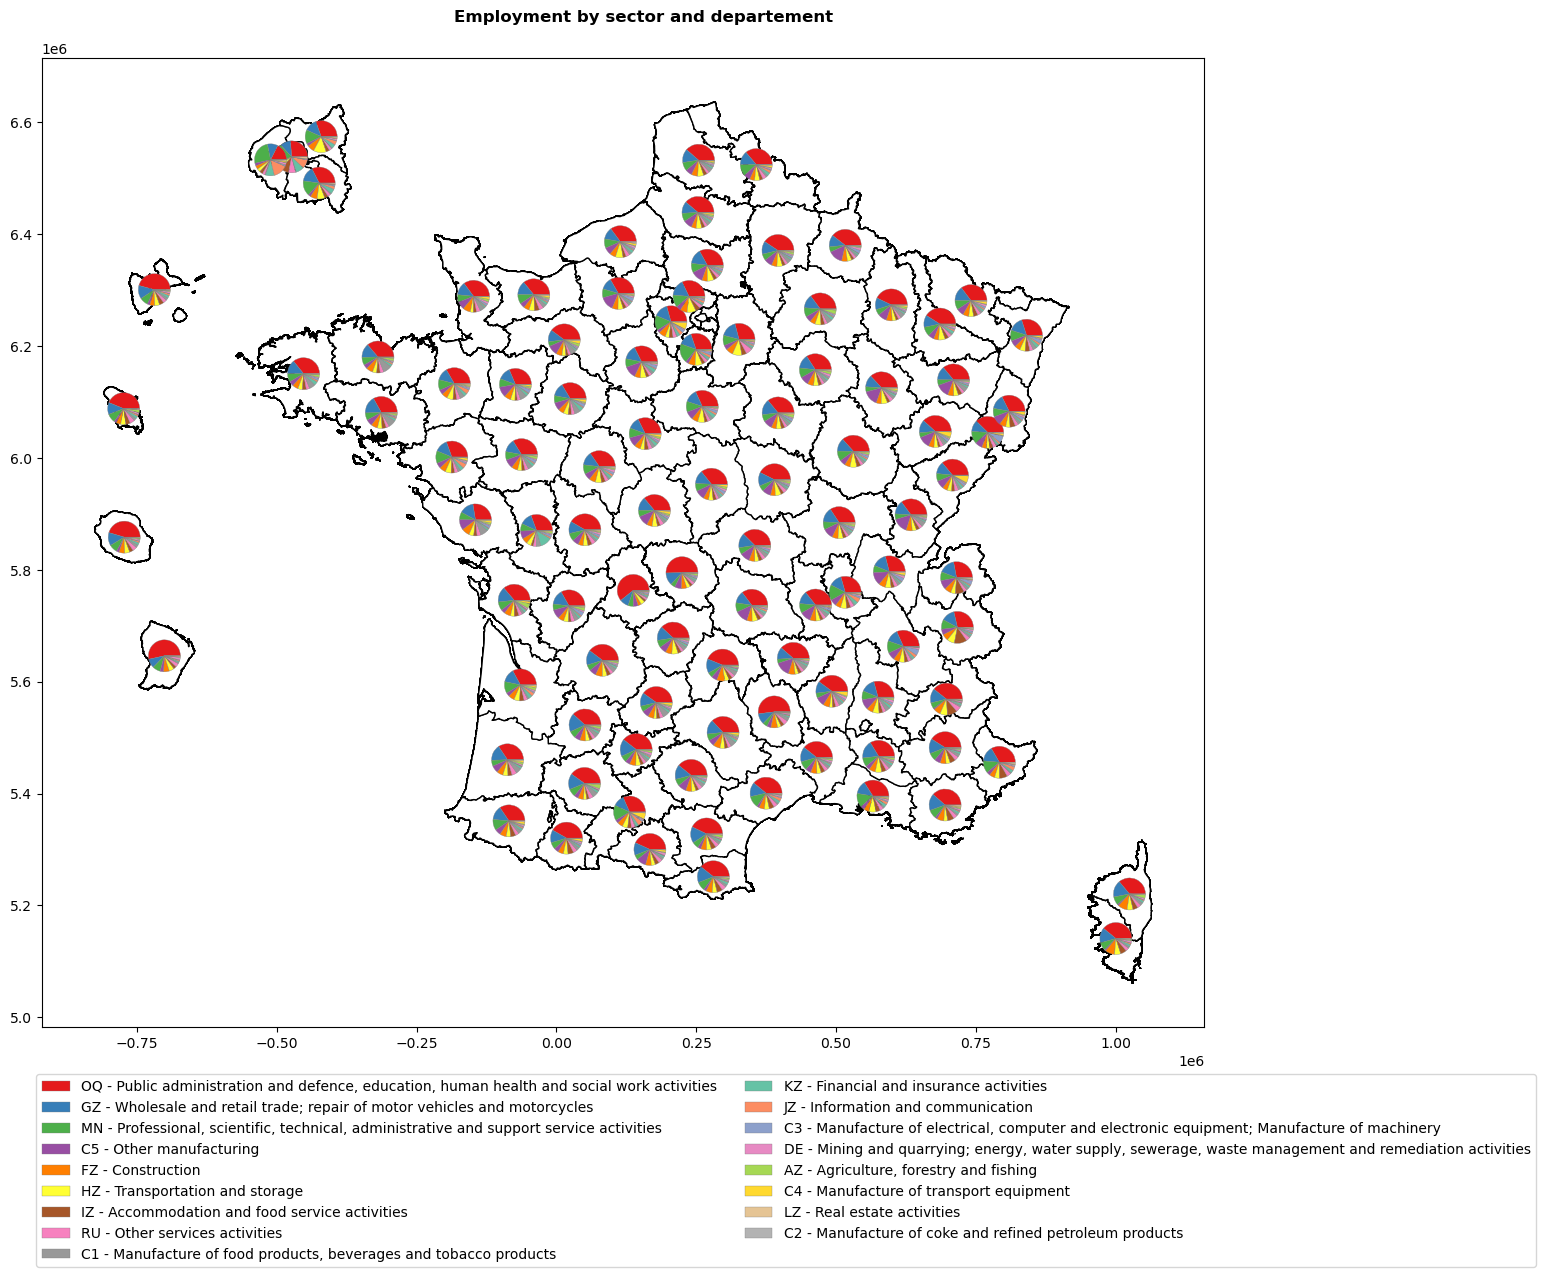

In [18]:
# draw plot

def extract_lon(x):
    return wkt.loads(x).xy[0][0]
def extract_lat(x):
    return wkt.loads(x).xy[1][0]

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

for idep in list_dep:
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    df["lon"] = df["center"].apply(lambda x: extract_lon(x))
    df["lat"] = df["center"].apply(lambda x: extract_lat(x))

    df = df[df["lon"] == min(df["lon"])].reset_index(drop=True)
    center = df.loc[0,"lon"], df.loc[0,"lat"]

    ratios = df["employment_share"]

    ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=center, bbox_transform=ax.transData)
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)

plt.suptitle('Employment by sector and departement', x = 0.4, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.legend(emplTot.index, loc="lower left", bbox_to_anchor=(-27, -9), ncol=2)

plt.show()